# Multivariate Anomaly Detection API Demo Notebook

## Contents

1. [Introduction](#intro)
2. [Create and Anomaly Detector](#ad)
1. [Create an Storage Account](#sa)
1. [Prepare your data](#data)
1. [Train a model](#train)
1. [Inference](#inference)
1. [List models](#list)
1. [Delete model](#delete)
1. [Visualization](#vis)

## 1. Introdution <a class="anchor" id="intro"></a>
This notebook shows how to use [Multivariate Anomaly Detection API (GA version)](https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/overview) in Anomaly Detector service. Please follow the steps to try it out, you can either [join Teams Group](https://forms.office.com/Pages/ResponsePage.aspx?id=v4j5cvGGr0GRqy180BHbRxSkyhztUNZCtaivu8nmhd1UQ1VFRDA0V1dUMDJRMFhOTzFHQ1lDTVozWi4u) for any questions and get updated for product iteration, or email us via [AnomalyDetector@microsoft.com](mailto:anomalydetector@microsoft.com).

There are 7 APIs provided in Multivariate Anomaly Detection:
* **Training**: Use `Train Model API` to create and train a model, then use `Get Model Status API` to get the status and model metadata.
* **Inference**: 
    * Use `Async Inference API` to trigger an asynchronous inference process and use `Get Inference results API` to get detection results on a batch of data.
    * You could also use `Sync Inference API` to trigger a detection on one timestamp every time.
* **Other operations**: `List Model API` and `Delete Model API` are supported in MVAD for model management.
![](https://i.imgur.com/PQ7h6Ix.png)
i

|API Name| Method | Path  | Description |
| ------ | ---- | ----------- | ------ | 
|**Train Model**| POST       |  `{endpoint}`/anomalydetector/v1.1/multivariate/models    |   Create and train a model          |
|**Get Model Status**|     GET   |   `{endpoint}`anomalydetector/v1.1/multivariate/models/`{modelId}`   |     Get model status and model metadata with `modelId`   |
|**Async Inference**|    POST    |  `{endpoint}`/anomalydetector/v1.1/multivariate/models/`{modelId}`:detect-batch    |          Trigger an asynchronous inference with `modelId`   |
|**Get Inference Results**|     GET   |  `{endpoint}`/anomalydetector/v1.1/multivariate/detect-batch/`{resultId}`    |       Get asynchronous inference resulsts with `resultId`      |
|**Sync Inference**|   POST     |   `{endpoint}`/anomalydetector/v1.1/multivariate/models/`{modelId}`:detect-last   |      Trigger a synchronous inference with `modelId`       |
|**List Model**|     GET   |  `{endpoint}`/anomalydetector/v1.1/multivariate/models    |      List all models       |
|**Delete Model**|     DELET   |  `{endpoint}`/anomalydetector/v1.1/multivariate/models/`{modelId}`    |     Delete model with `modelId`       |

## 2. Create an Anomaly Detector <a class="anchor" id="ad"></a>


* [Create an Azure subscription](https://azure.microsoft.com/free/cognitive-services) if you don't have one.
* [Create an Anomaly Detector resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesAnomalyDetector) and get your `endpoint` and `key`, paste them in the cell below.

![](https://i.imgur.com/M7qATAY.png)

In [1]:
# The ENDPOINT should be like: https://mvad-sample.cognitiveservices.azure.com/anomalydetector/v1.1
ENDPOINT = "https://fianomalydetector.cognitiveservices.azure.com/anomalydetector/v1.1"
HEADERS = {
    "Ocp-Apim-Subscription-Key": "bbaad2c3a2924be59ac183e4b78bdce2"
}


## 3. Create an Storage Account <a class="anchor" id="sa"></a>

1. [Create a Storage Account](https://ms.portal.azure.com/#create/Microsoft.StorageAccount-ARM).
1. Go to **Access Control(IAM)**, and select **+ADD** to **Add role assignment**.
3. Search role of **Storage Blob Data Reader**, **click on it** and then select **Next**.
4. Select assign access to **Managed identity**, and **Select Members**, then choose the anomaly detector resource that you created earlier, then select **Review + assign**.

![](https://i.imgur.com/dsTsuxI.gif)


## 4. Prepare your data <a class="anchor" id="data"></a>

### Download sample data
Multivariate Anomaly Detection supports two types of data schema for training and async inference: **`Multiple Tables`** and **`One Table`**.

*  Download [One Table sample data](https://mvaddataset.blob.core.windows.net/public-sample-data/sample_data_5_3000.csv)
* Download [Multiple Tables sample data](https://mvaddataset.blob.core.windows.net/public-sample-data/sample_data_5_3000.zip) and unzip it.

### Upload data to Storage Account

1. Go to your Storage Account, select **Containers** and create a new container.
2. Select **Upload** to upload the folder *(for multiple tables)* or the CSV file *(for one table*) that you downloaded earlier.
3. Click on the data that you uploaded and copy the **Blob URL** to somewhere for further steps.

In [18]:
# If your data is one CSV file, please set the dataSchema as `OneTable`, if your data is multiple CSV files in a folder, please set the dataSchema as `MultiTable`.
DATA_SCHEMA="OneTable"
# The data source url should be like: https://mvaddataset.blob.core.windows.net/sample-multitable/sample_data_5_3000.csv
DATA_SOURCE_URL= "https://fianomalystorage.blob.core.windows.net/data/sample_data_5_3000.csv"

In [19]:
# Run directly
API_MODEL = "{endpoint}/multivariate/models"
API_MODEL_STATUS = "{endpoint}/multivariate/models/{model_id}"
API_MODEL_BATCH_INFERENCE = "{endpoint}/multivariate/models/{model_id}:detect-batch"
API_MODEL_LAST_INFERENCE = "{endpoint}/multivariate/models/{model_id}:detect-last"
API_RESULTS = "{endpoint}/multivariate/detect-batch/{result_id}"
API_DELETE = "{endpoint}/multivariate/models/{model_id}"

## 5. Train a model <a class="anchor" id="train"></a>

In [20]:
import requests
import json
import pandas as pd

In [21]:
SLIDING_WINDOW = 200
# Change the TRAINING_START_TIME and TRAINING_END_TIME if you use another dataset.
TRAINING_START_TIME = "2021-01-01T00:00:00Z"
TRAINING_END_TIME = "2021-01-02T09:19:00Z"
data = {
    "slidingWindow": SLIDING_WINDOW,
    "alignPolicy": {
        "alignMode": "Outer",
        "fillNAMethod": "Linear", 
        "paddingValue": 0
    },
    "dataSource": DATA_SOURCE_URL,
    "dataSchema": DATA_SCHEMA,
    "startTime": TRAINING_START_TIME, 
    "endTime": TRAINING_END_TIME, 
    "displayName": "SampleRequest"
}

res = requests.post(API_MODEL.format(endpoint=ENDPOINT), data=json.dumps(data), headers=HEADERS)
assert res.status_code == 201, f"Error occurred. Error message: {res.content}"
# Print the following line to get the epochId which could help you better know the status of model. There are 100 epochIds in total.
# print(res.content)
location = res.headers['Location']
model_id = location[location.rindex('/')+1:]
print(f"Model is created with the modelId: {model_id}, please check the model status using next cell.😉")

Model is created with the modelId: baa5a002-6e54-11ed-be05-06f231c651c5, please check the model status using next cell.😉


The training might takes few minutes to few hours which depends on you data size, you could take a coffee ☕ and come back to check the model status.

### Get model status
After the model is created, you need to run the below code several times to get the status of model until it's **READY** for inference.

In [26]:
res = requests.get(API_MODEL_STATUS.format(endpoint=ENDPOINT, model_id = model_id), headers=HEADERS)
assert res.status_code == 200, f"Error occurred. Error message: {res.content}"
res_content = json.loads(res.content)
# print(json.dumps(res_content))
print(f"Model status: {res_content['modelInfo']['status']}.")
print("You could run the inference below once the model status is READY.")

Model status: READY.
You could run the inference below once the model status is READY.


## 6. Inference <a class="anchor" id="inference"></a>

There are two types of inference:
* Batch inference (asynchronous)
* Streaming inference (synchronous)

You could use the `Batch Inference AP` for a long period of data validation or for a micro-batch task, which works in an asynchronous way together with the `Get Inference Results API`. If your case is more like real-time or near real-time, the `Streaming Inference API` might be a good choice for you since it will present the anomaly results immediately once you call this API and get every timestamp detected per call. 

### Trigger a batch inference

In [27]:
# Change the INFERENCE_START_TIME and INFERENCE_END_TIME if you use another dataset.
INFERENCE_START_TIME = "2021-01-02T12:00:00Z"
INFERENCE_END_TIME = "2021-01-03T00:00:00Z"

data = {
    "dataSource": DATA_SOURCE_URL,
    # The topContributorCount specify how many contributed variables you care about in the results.
    "topContributorCount": 10,
    "startTime": INFERENCE_START_TIME, 
    "endTime": INFERENCE_END_TIME
}

res = requests.post(API_MODEL_BATCH_INFERENCE.format(endpoint=ENDPOINT, model_id=model_id), 
                    data=json.dumps(data), headers=HEADERS)

# print(res.headers)
# print(res.content)
assert res.status_code == 202, f"Error occurred. Error message: {res.content}"
result_id = res.headers["operation-id"]
print(f"A batch inference is triggered with the resultId: {result_id}, please get the detection results using the next cell.")

A batch inference is triggered with the resultId: 401fcfc8-6e55-11ed-93e8-26a9ffcd25cf, please get the detection results using the next cell.


### Get batch inference results

In [28]:
res = requests.get(API_RESULTS.format(endpoint=ENDPOINT, result_id=result_id), headers=HEADERS)
assert res.status_code == 200, f"Error occurred. Error message: {res.content}"
batch_results=json.loads(res.content)
# print(batch_results)
batch_results_df=pd.json_normalize(batch_results,record_path=['results'],errors='ignore')
batch_results_df

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation
0,2021-01-02T12:00:00Z,[],False,0.000000,0.337481,[]
1,2021-01-02T12:01:00Z,[],False,0.000000,0.238778,[]
2,2021-01-02T12:02:00Z,[],False,0.000000,0.163547,[]
3,2021-01-02T12:03:00Z,[],False,0.000000,0.237346,[]
4,2021-01-02T12:04:00Z,[],False,0.000000,0.245659,[]
...,...,...,...,...,...,...
716,2021-01-02T23:56:00Z,[],False,0.000000,0.249437,[]
717,2021-01-02T23:57:00Z,[],False,0.000000,0.342212,[]
718,2021-01-02T23:58:00Z,[],True,0.299054,0.513859,"[{'variable': 'series_1', 'contributionScore':..."
719,2021-01-02T23:59:00Z,[],False,0.000000,0.448912,[]


### Streaming Inference

In [34]:
import json

with open("../../data/anomalydetector/multivariate/5_3000.json", "r") as f:
    sample_input = json.load(f)

url = API_MODEL_LAST_INFERENCE.format(endpoint=ENDPOINT,model_id=model_id)
payload = sample_input

res = requests.post(url, headers=HEADERS, data=json.dumps(payload))
# print(res.content)
streaming_results=json.loads(res.content)
streaming_results_df=pd.json_normalize(streaming_results,record_path=['results'])
streaming_results_df

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation
0,2021-01-03T01:59:00Z,[],False,0.0,0.272454,[]


## 7. List models <a class="anchor" id="list"></a>

You could check the status of your model and your model list. The `currentCount` means how many model you've created in your Anomaly Detector resource, and the `maxCount` means the limitation of your model number in your Anomaly Detector resource.

In [30]:
res = requests.get(API_MODEL.format(endpoint=ENDPOINT), headers=HEADERS)
assert res.status_code == 200, f"Error occurred. Error message: {res.content}"
# print(res.content)

model_list= pd.json_normalize(json.loads(res.content),record_path=['models'],meta=['currentCount','maxCount'])
model_list[['modelId','modelInfo.displayName','modelInfo.status','modelInfo.dataSource','currentCount','maxCount']]

,modelId,modelInfo.displayName,modelInfo.status,modelInfo.dataSource,currentCount,maxCount
0,baa5a002-6e54-11ed-be05-06f231c651c5,SampleRequest,READY,https://fianomalystorage.blob.core.windows.net...,1,1000


## 8. Delete model <a class="anchor" id="delete"></a>

In [11]:
res = requests.delete(API_DELETE.format(endpoint=ENDPOINT, model_id=model_id), headers=HEADERS)
assert res.status_code == 204, f"Error occurred. Error message: {res.content}"
print("Successfully deleted this model: "+ model_id)

Successfully deleted this model: eb65081c-5a2d-11ed-863d-b618fab0ff58


# 9. Visualization <a class="anchor" id="vis"></a>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [33]:
raw_data=pd.read_csv('../../data/anomalydetector/multivariate/sample_data_5_3000.csv')
df_merge=pd.merge(batch_results_df,raw_data, on="timestamp")
df_merge

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation,series_0,series_1,series_2,series_3,series_4
0,2021-01-02T12:00:00Z,[],False,0.000000,0.337481,[],1.406643,0.038892,-0.900322,-0.496920,1.835452
1,2021-01-02T12:01:00Z,[],False,0.000000,0.238778,[],0.498293,-1.203895,-0.015028,0.639817,1.336381
2,2021-01-02T12:02:00Z,[],False,0.000000,0.163547,[],0.482624,0.117251,-0.346558,0.380744,1.216002
3,2021-01-02T12:03:00Z,[],False,0.000000,0.237346,[],0.135886,0.175647,0.529109,-1.525938,-0.921328
4,2021-01-02T12:04:00Z,[],False,0.000000,0.245659,[],-1.056639,-1.452493,-0.204444,-0.408568,-0.532862
...,...,...,...,...,...,...,...,...,...,...,...
716,2021-01-02T23:56:00Z,[],False,0.000000,0.249437,[],-0.496276,-0.327522,-0.982608,-1.152828,0.732866
717,2021-01-02T23:57:00Z,[],False,0.000000,0.342212,[],0.833020,0.285757,-1.691492,-1.481046,0.214137
718,2021-01-02T23:58:00Z,[],True,0.299054,0.513859,"[{'variable': 'series_1', 'contributionScore':...",0.864732,2.680365,1.244429,0.827081,-1.171265
719,2021-01-02T23:59:00Z,[],False,0.000000,0.448912,[],-0.742697,-1.620215,-1.778069,-1.627223,0.172657


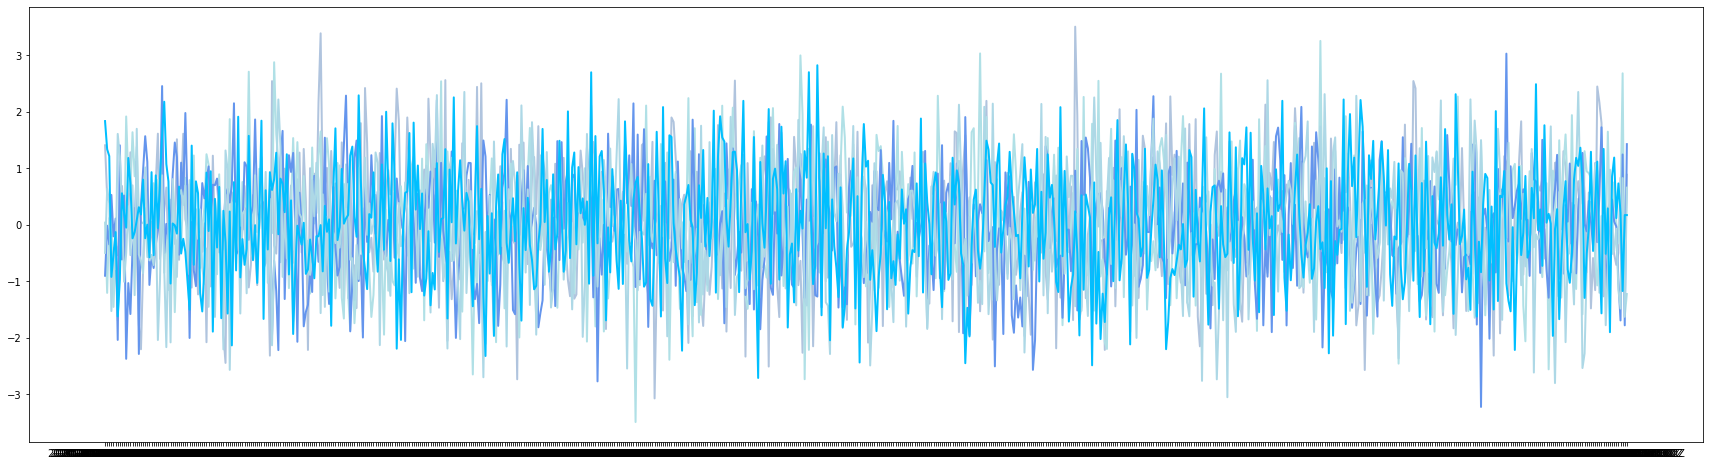

In [35]:
####### Main Figure #######
plt.figure(figsize=(30,8))
plt.plot(df_merge['timestamp'],df_merge['series_0'], color='lightsteelblue', linestyle='solid', linewidth=2, label='series_0')
plt.plot(df_merge['timestamp'],df_merge['series_1'], color='powderblue', linestyle='solid', linewidth=2, label='series_1')
plt.plot(df_merge['timestamp'],df_merge['series_2'], color='cornflowerblue', linestyle='solid', linewidth=2, label='series_2')
plt.plot(df_merge['timestamp'],df_merge['series_3'], color='lightblue', linestyle='solid', linewidth=2, label='series_3')
plt.plot(df_merge['timestamp'],df_merge['series_4'], color='deepskyblue', linestyle='solid', linewidth=2, label='series_4')

C:\Users\faismali\AppData\Local\Temp\ipykernel_3004\4229059390.py:21: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=1,linewidth=3)


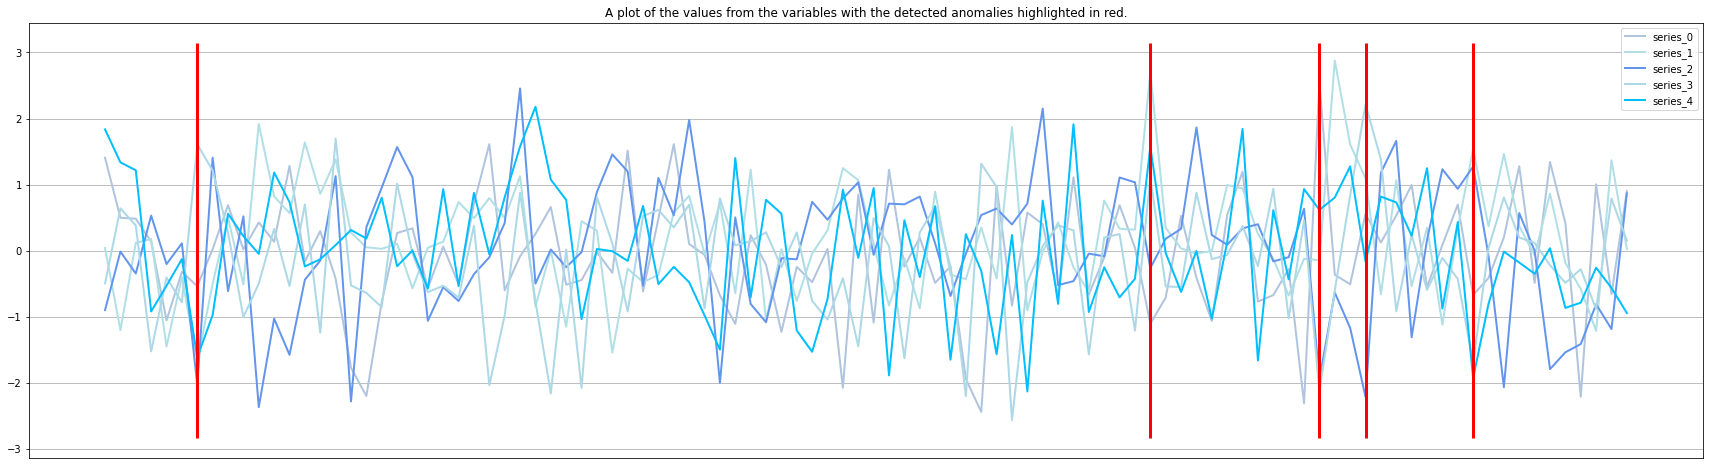

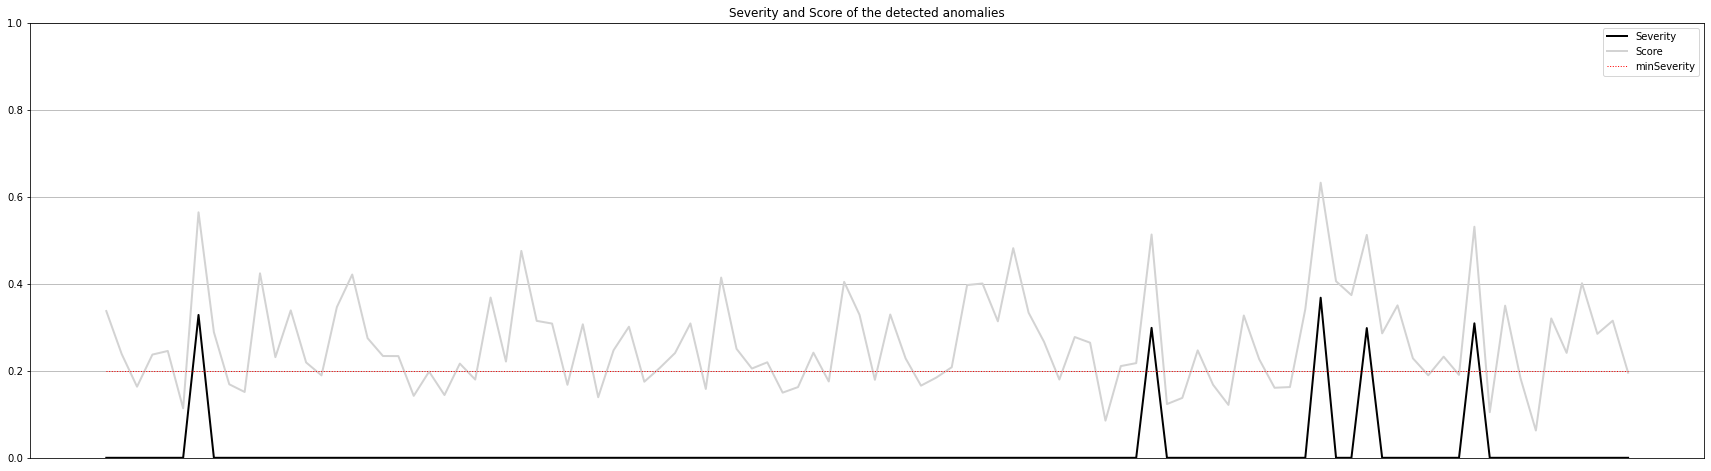

In [36]:
# You could use this parameter to sift out the anomalies, the less this number is, the more anomalies will be marked out.
minSeverity = 0.2

# Only presents first 100 rows to see clearer graph.
df = df_merge.iloc[:100]

####### Main Figure #######
plt.figure(figsize=(30,8))
plt.plot(df['timestamp'],df['series_0'], color='lightsteelblue', linestyle='solid', linewidth=2, label='series_0')
plt.plot(df['timestamp'],df['series_1'], color='powderblue', linestyle='solid', linewidth=2, label='series_1')
plt.plot(df['timestamp'],df['series_2'], color='cornflowerblue', linestyle='solid', linewidth=2, label='series_2')
plt.plot(df['timestamp'],df['series_3'], color='lightblue', linestyle='solid', linewidth=2, label='series_3')
plt.plot(df['timestamp'],df['series_4'], color='deepskyblue', linestyle='solid', linewidth=2, label='series_4')

plt.grid(axis='y')
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.legend()

anoms = list(df["value.severity"] >= minSeverity)
_, _, ymin, ymax = plt.axis()
plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=1,linewidth=3)

plt.legend()
plt.title('A plot of the values from the variables with the detected anomalies highlighted in red.')
plt.show()


####### Severity Figure #######
plt.figure(figsize=(30,8))
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.plot(df['timestamp'],df['value.severity'], color='black', linestyle='solid', linewidth=2, label='Severity')
plt.plot(df['timestamp'],df['value.score'], color='lightgrey', linestyle='solid', linewidth=2, label='Score')
plt.plot(df['timestamp'],[minSeverity]*len(df['value.severity']), color='red', linestyle='dotted', linewidth=1, label='minSeverity')
plt.grid(axis='y')
plt.legend()
plt.ylim((0,1))
plt.title("Severity and Score of the detected anomalies")
plt.show()

In [37]:
# Display only the anomalous timestamps.
df_anomaly = df[df['value.isAnomaly']== True]
df_anomaly

,timestamp,errors,value.isAnomaly,value.severity,value.score,value.interpretation,series_0,series_1,series_2,series_3,series_4
6,2021-01-02T12:06:00Z,[],True,0.328512,0.564476,"[{'variable': 'series_2', 'contributionScore':...",-0.539582,-1.688357,-2.036156,1.608503,-1.618857
68,2021-01-02T13:08:00Z,[],True,0.298812,0.513443,"[{'variable': 'series_1', 'contributionScore':...",-1.107553,2.708357,-0.265096,1.114120,1.574517
79,2021-01-02T13:19:00Z,[],True,0.368108,0.632514,"[{'variable': 'series_0', 'contributionScore':...",2.542432,-0.147229,-1.951820,-2.131433,0.616188
82,2021-01-02T13:22:00Z,[],True,0.298299,0.512561,"[{'variable': 'series_2', 'contributionScore':...",0.557954,1.096061,-2.216703,2.217523,-0.166912
89,2021-01-02T13:29:00Z,[],True,0.309225,0.531335,"[{'variable': 'series_3', 'contributionScore':...",-0.671966,1.534570,1.272315,-1.707646,-1.931589


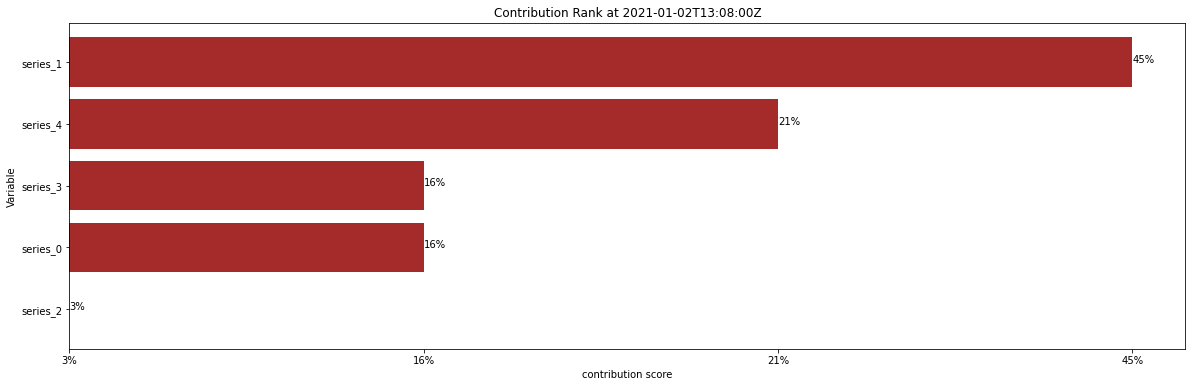

The last column indicates the correlated variables with the first column variable, whose correlations caused the anomaly.


,variable,contributionScore,correlationChanges.changedVariables
0,series_1,0.448368,"[series_3, series_4]"
1,series_4,0.206326,"[series_3, series_4]"
2,series_3,0.159381,"[series_3, series_4]"
3,series_0,0.157078,"[series_3, series_4]"
4,series_2,0.028847,"[series_3, series_4]"


In [38]:
from tkinter.font import BOLD
from turtle import color


anomaly_index = 1
d = df_anomaly.iloc[anomaly_index]['value.interpretation'][::-1]
timestamp = df_anomaly.iloc[anomaly_index]['timestamp']
correlatedVar = df_anomaly.iloc[anomaly_index]['value.interpretation']

x=[item.get('variable') for item in d]
y=[item.get('contributionScore') for item in d]
Z=[item.get('correlationChanges') for item in d]

l=[]
for i in y:
    i =  "%.f%%" % (i * 100)
    l.append(i)

plt.figure(figsize=(20,6))


plt.barh(x, l,color="brown",alpha=1)

for index, value in enumerate(l):
    plt.text(value, index,str(value) )

# setting label of y-axis
plt.ylabel("Variable")

# setting label of x-axis
plt.xlabel("contribution score")
plt.title("Contribution Rank at "+timestamp)

plt.show()
print("The last column indicates the correlated variables with the first column variable, whose correlations caused the anomaly.")
pd.json_normalize(correlatedVar)